# Send

In [1]:
from PIL import Image
import numpy as np
import socket
import matplotlib.pyplot as plt
import time
import os

/home/daniel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


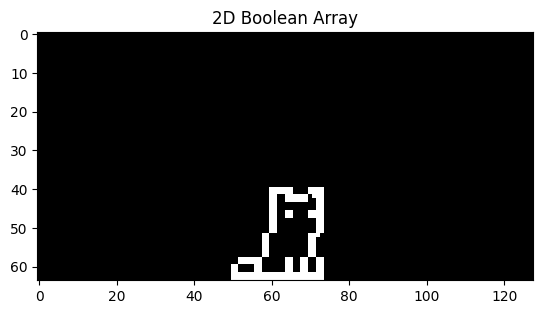

In [2]:
def read_and_pad_image(image_path, target_size=(128, 64)):
    """
    Read a PNG image and pad it to the target size.
    
    :param image_path: string, path to the image file
    :param target_size: tuple, target size for padding (width, height)
    :return: 2D numpy array of booleans
    """
    # Open the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    
    # Resize the image if it's larger than the target size
    if image.size[0] > target_size[0] or image.size[1] > target_size[1]:
        image.thumbnail(target_size, Image.ANTIALIAS)

    min_size = min(target_size[0], target_size[1])
    resized_shape = (min_size, min_size)
    image = image.resize(resized_shape)
    
    # Create a new image with the target size and paste the original image into it
    padded_image = Image.new('L', target_size, color=255)  # White background
    padded_image.paste(image, ((target_size[0] - image.size[0]) // 2, 
                               (target_size[1] - image.size[1]) // 2))
    
    # Convert the image to a 2D boolean array (True for black, False for white)
    bool_array = np.array(padded_image) < 128  # Assuming a threshold of 128 for binarization
    
    return bool_array

def plot_bool_array(bool_array):
    """
    Plot a 2D boolean array using matplotlib.
    
    :param bool_array: 2D numpy array of booleans
    """
    plt.imshow(bool_array, cmap='gray', interpolation='nearest')
    plt.title('2D Boolean Array')
    plt.show()

image_path = 'frames/frame_0.png'  # Replace with your image path
bool_array = read_and_pad_image(image_path)
plot_bool_array(bool_array)

In [3]:
def bool_array_to_byte_array(bool_array):
    """
    Convert a 2D boolean array to a byte array.
    
    :param bool_array: 2D numpy array of booleans
    :return: bytearray
    """
    flat_bool_array = bool_array.flatten()
    byte_array = bytearray()
    
    for i in range(0, len(flat_bool_array), 8):
        byte = 0
        for bit in range(8):
            if i + bit < len(flat_bool_array) and flat_bool_array[i + bit]:
                byte |= (1 << bit)
        byte_array.append(byte)
    
    return byte_array


byte_array = bool_array_to_byte_array(bool_array)

print(byte_array)
print(len(byte_array))

bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [16]:
# Define the IP address and port of the ESP8266
ESP8266_IP = '192.168.1.8'  # Replace with the actual IP address of your ESP8266
ESP8266_PORT = 12345

def send_data(byte_array, ip, port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((ip, port))
        s.sendall(byte_array)


send_data(byte_array, ESP8266_IP, ESP8266_PORT)

In [18]:
frame_ids_natural = [0 for _ in range(10)] + [i for i in range(0, 4)] + [0 for _ in range(10)]
frame_ids_looking_around = [i for i in range(3, 11)] + [i for i in range(10, 4, -1)]
frame_ids_licking = [i for i in range(16, 28)] + [i for i in range(27, 15, -1)]

frame_ids = frame_ids_natural + frame_ids_looking_around + frame_ids_natural + frame_ids_licking + frame_ids_natural

for frame_id in frame_ids:
    frame = f'frames/frame_{frame_id}.png'
    if os.path.exists(frame):
        bool_array = read_and_pad_image(frame)
        byte_array = bool_array_to_byte_array(bool_array)
        send_data(byte_array, ESP8266_IP, ESP8266_PORT)
        time.sleep(0.08)